In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd '/content/drive/My Drive/Colab Notebooks/Paddy Segmentation'

/content/drive/My Drive/Colab Notebooks/Paddy Segmentation


In [0]:
!pip install rasterio
!pip install fiona

     |████████████████████████████████| 15.1MB 2.6MB/s 
     |████████████████████████████████| 11.9MB 2.7MB/s 
  Created wheel for munch: filename=munch-2.3.2-py2.py3-none-any.whl size=6614 sha256=51a7809957d3c64600c68f380149a53420548d8bc8b8dbb10fbe189edcb91dda
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch


In [0]:
import fiona
import rasterio
import rasterio.mask
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import pandas as pd
import pprint

In [0]:
src1 = []
src2 = []
with fiona.open("Input/Shape file /paddy_bg.shp", "r") as shapefile:
    for i in shapefile:
        pprint.pprint(i)

    features = [f["properties"] for f in shapefile]
    for i in range(len(features)):
      if(features[i]['class'] == 'paddy'):
        src1.append(shapefile[i])
      elif(features[i]['class'] == 'background'):
        src2.append(shapefile[i])
       
    # pprint.pprint(src1)

    geo_paddy = [geo_paddy["geometry"] for geo_paddy in src1]
    geo_background = [geo_background["geometry"] for geo_background in src2]
    # pprint.pprint(geo_paddy)
     
pprint.pprint(features)

    

{'geometry': {'coordinates': [[(100.28420411913307, 14.917738642142915),
                               (100.28577157998654, 14.917738642142915),
                               (100.28577157998654, 14.915968922457303),
                               (100.28420411913307, 14.915968922457303),
                               (100.28420411913307, 14.917738642142915)]],
              'type': 'Polygon'},
 'id': '0',
 'properties': OrderedDict([('id', 2), ('class', 'background')]),
 'type': 'Feature'}
{'geometry': {'coordinates': [[(100.27479935401217, 14.912748891759326),
                               (100.2759618874785, 14.912722767411768),
                               (100.2759383430815, 14.911675041745333),
                               (100.27477580961518, 14.911701166092891),
                               (100.27479935401217, 14.912748891759326)]],
              'type': 'Polygon'},
 'id': '1',
 'properties': OrderedDict([('id', 6), ('class', 'background')]),
 'type': 'Feature'}
{'ge

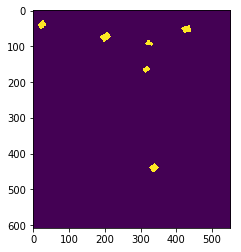

In [0]:
with rasterio.open("Input/img.tif") as src:
    height = src.height
    width = src.width
    src_transform = src.transform
    out_meta = src.meta.copy()
    out_meta.update({'count':1})
mask_paddy = rasterio.features.geometry_mask(geo_paddy, (height, width), src_transform,invert=True, all_touched=True).astype(np.uint32)
mask_background = rasterio.features.geometry_mask(geo_background, (height, width), src_transform,invert=True, all_touched=True).astype(np.uint32)

plt.imshow(mask_paddy)
# plt.imshow(mask_background)

(608, 552)
1


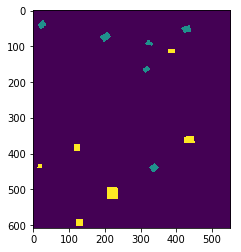

In [0]:
mask = 1*mask_paddy+2*mask_background
print(mask.shape)
plt.imshow(mask)
with rasterio.open("Input/mask.tif", "w", **out_meta) as dest:
    dest.write(mask,indexes=1)
    print(dest.count)

In [0]:
mask = mask.flatten().reshape(-1,1)
print(len(mask))

Img_pixels = []
with rasterio.open("Input/img.tif") as src:
  Img_pixels.append(src.read())

Img_pixels = np.array(Img_pixels)
print(Img_pixels)



Img_pixels = np.reshape(Img_pixels,(4,height,width))
print(Img_pixels.shape)
print(Img_pixels[0].shape)

pixel_bancolor = [Img_pixels[i].flatten() for i in range(4)]
pixel_bancolor = np.array(pixel_bancolor).T
print(pixel_bancolor)

pixel_color_padding=np.hstack((pixel_bancolor,mask))
print(pixel_color_padding)

labled_pixels = [pixel_color_padding[i,:] for i in range(mask.shape[0]) if(mask[i] > 0)]
labled_pixels = np.array(labled_pixels)
print(labled_pixels)

df = pd.DataFrame(labled_pixels, columns = ['ban1', 'ban2', 'ban3', 'ban4', 'padding'])
print(df.shape)
df.to_csv('Input/input_model.csv')

335616
[[[[1082 1076 1064 ... 1076 1080 1074]
   [1082 1076 1064 ... 1082 1096 1074]
   [1090 1097 1066 ... 1076 1075 1055]
   ...
   [1116 1132 1119 ... 1086 1182 1248]
   [1105 1097 1117 ... 1197 1199 1244]
   [1117 1117 1122 ... 1197 1199 1244]]

  [[1030 1021 1029 ...  950  941  943]
   [1030 1021 1029 ...  947  936  924]
   [1031 1031 1052 ...  954  946  932]
   ...
   [1123 1123 1100 ...  994 1150 1211]
   [1119 1115 1103 ... 1166 1167 1175]
   [1100 1112 1116 ... 1166 1167 1175]]

  [[ 671  672  674 ...  728  709  694]
   [ 671  672  674 ...  703  701  685]
   [ 668  658  655 ...  704  676  667]
   ...
   [ 719  713  695 ...  744 1027 1135]
   [ 711  689  684 ... 1030 1079 1129]
   [ 695  698  731 ... 1030 1079 1129]]

  [[2866 2840 2882 ...  900  841  804]
   [2866 2840 2882 ...  978  916  860]
   [3171 3114 3078 ... 1039  950  898]
   ...
   [3296 3419 3470 ... 2588 2443 2084]
   [3361 3465 3458 ... 2621 2280 1935]
   [3364 3376 3311 ... 2621 2280 1935]]]]
(4, 608, 552)
(608, 